<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#tl;dr" data-toc-modified-id="tl;dr-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>tl;dr</a></span></li><li><span><a href="#setup" data-toc-modified-id="setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>neural network architecture</a></span></li><li><span><a href="#data" data-toc-modified-id="data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#training" data-toc-modified-id="training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>training</a></span></li><li><span><a href="#results" data-toc-modified-id="results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>results</a></span></li></ul></div>

# tl;dr

In this notebook we will try to make some experiments with the **Damped Harmonic Oscillator** (DHO) synthetic data. Here the goal is to explore the ability of the model to learn the ODE's solution given that we only know data from lower and upper bounds of domain.

# setup

In [1]:
import pprint
import functools
import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from IPython.display import display

%matplotlib inline

# neural network architecture

In [2]:
class MultiLayerPerceptronRegressor(nn.Module):
    """
    feedforward neural network regressor
    """
    def __init__(self, layers:list, activation:torch.nn.modules.activation):
        super(MultiLayerPerceptronRegressor, self).__init__()
        _architecture = list()

        for index, layer in enumerate(layers[:-2]):
            _architecture.append(nn.Linear(layer, layers[index+1]))
            _architecture.append(activation())
        _architecture.append(nn.Linear(layers[-2], layers[-1]))
        
        self.architecture = nn.Sequential(*_architecture)

    def forward(self, x):
        return self.architecture(x)

torch.manual_seed(33) ;


$$ \ddot{x} + \frac{\mu}{m} \dot{x} + \frac{k}{m} x = 0 $$

# data

,time,displacement
0,0.000000,49.999996
1,0.006012,47.784603
2,0.012024,41.438625
3,0.018036,31.667374
4,0.024048,19.452913


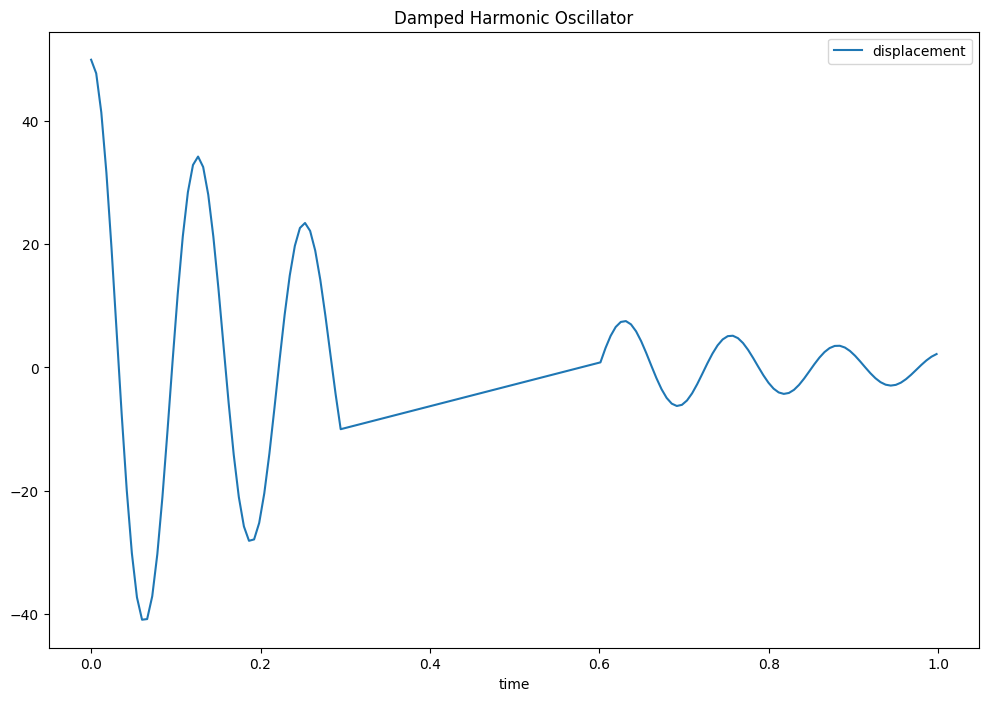

In [2]:
X = pd.read_csv("../data/01_raw/damped-harmonic-oscillator/extrapolation/train.csv").query("time <= 50")

# min_max_scaler = MinMaxScaler()
# X["time"] = min_max_scaler.fit_transform(X["time"].values.reshape(-1, 1))

def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = 50 * exp*2*A*cos
    return y


d, w0 = 3, 50
x = torch.linspace(0, 1, 500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)

X = pd.DataFrame({"time": torch.cat([x.squeeze()[0:150:3],x.squeeze()[300::3]]), 
                  "displacement": torch.cat([y.squeeze()[0:150:3],y.squeeze()[300::3]])})

display(X.head())

X.plot(x="time", y="displacement", figsize=(12, 8), title="Damped Harmonic Oscillator") ;

# training

MultiLayerPerceptronRegressor(
  (architecture): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)


  0%|                                                 | 0/75000 [00:00<?, ?it/s]/home/dusoudeth/Documentos/github/pinn/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|▌                                    | 1050/75000 [00:04<04:15, 289.69it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 409.945892, Physics Loss: 10758.532227, x0 Loss: 2483.435791, v0 Loss: 5.812735, Total Loss: 410.053467


  3%|▉                                    | 2023/75000 [00:07<05:39, 215.09it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 220.717484, Physics Loss: 3215134.750000, x0 Loss: 615.762268, v0 Loss: 187536.546875, Total Loss: 252.868835


  4%|█▍                                   | 3038/75000 [00:12<05:49, 205.85it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 95.160042, Physics Loss: 4541213.500000, x0 Loss: 1.511764, v0 Loss: 362993.000000, Total Loss: 140.572174


  5%|█▉                                   | 4028/75000 [00:17<05:54, 200.29it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 64.478279, Physics Loss: 4686390.500000, x0 Loss: 15.104685, v0 Loss: 512068.812500, Total Loss: 111.342178


  7%|██▍                                  | 5037/75000 [00:21<05:28, 213.09it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 46.820900, Physics Loss: 4420840.500000, x0 Loss: 30.237749, v0 Loss: 666334.937500, Total Loss: 91.029305


  8%|██▉                                  | 6023/75000 [00:26<05:39, 203.47it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 35.787106, Physics Loss: 4251564.500000, x0 Loss: 15.353349, v0 Loss: 749319.750000, Total Loss: 78.302750


  9%|███▍                                 | 7031/75000 [00:31<05:17, 214.33it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 28.937843, Physics Loss: 5312293.000000, x0 Loss: 11.713171, v0 Loss: 779600.625000, Total Loss: 82.060776


 11%|███▉                                 | 8037/75000 [00:36<05:22, 207.59it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 24.923923, Physics Loss: 3692851.500000, x0 Loss: 9.719569, v0 Loss: 886058.625000, Total Loss: 61.852436


 12%|████▍                                | 9027/75000 [00:41<05:21, 205.16it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 26.187313, Physics Loss: 3633581.750000, x0 Loss: 8.699646, v0 Loss: 826296.625000, Total Loss: 62.523129


 13%|████▊                               | 10022/75000 [00:45<05:14, 206.89it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 22.983160, Physics Loss: 3607219.750000, x0 Loss: 9.750920, v0 Loss: 884072.500000, Total Loss: 59.055359


 15%|█████▎                              | 11037/75000 [00:50<05:10, 206.01it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 20.622063, Physics Loss: 3520162.750000, x0 Loss: 9.265441, v0 Loss: 930025.937500, Total Loss: 55.823689


 16%|█████▊                              | 12027/75000 [00:55<05:07, 204.81it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 19.732849, Physics Loss: 3344163.250000, x0 Loss: 8.228072, v0 Loss: 930263.437500, Total Loss: 53.174480


 17%|██████▎                             | 13031/75000 [01:00<04:45, 217.21it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 18.579288, Physics Loss: 3047371.250000, x0 Loss: 8.109406, v0 Loss: 946703.250000, Total Loss: 49.053001


 19%|██████▋                             | 14040/75000 [01:05<04:41, 216.91it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 17.289131, Physics Loss: 2935241.500000, x0 Loss: 6.525064, v0 Loss: 941660.812500, Total Loss: 46.641548


 20%|███████▏                            | 15049/75000 [01:09<03:52, 258.22it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 15.181418, Physics Loss: 2235977.750000, x0 Loss: 6.247521, v0 Loss: 876530.437500, Total Loss: 37.541195


 21%|███████▋                            | 16049/75000 [01:14<03:23, 289.47it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 13.596113, Physics Loss: 2070859.125000, x0 Loss: 5.816708, v0 Loss: 861865.750000, Total Loss: 34.304703


 23%|████████▏                           | 17026/75000 [01:18<04:37, 208.68it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 12.730773, Physics Loss: 2036714.250000, x0 Loss: 5.905884, v0 Loss: 840183.625000, Total Loss: 33.097916


 24%|████████▋                           | 18057/75000 [01:22<03:09, 299.85it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 23.910530, Physics Loss: 1938593.375000, x0 Loss: 9.806987, v0 Loss: 633377.937500, Total Loss: 43.296463


 25%|█████████▏                          | 19044/75000 [01:25<02:57, 315.83it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 14.124449, Physics Loss: 2010612.375000, x0 Loss: 11.637909, v0 Loss: 550272.375000, Total Loss: 34.230572


 27%|█████████▌                          | 20022/75000 [01:29<04:24, 207.87it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 12.616073, Physics Loss: 1980496.625000, x0 Loss: 11.543985, v0 Loss: 558050.937500, Total Loss: 32.421040


 28%|██████████                          | 21032/75000 [01:33<04:03, 221.57it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 11.741060, Physics Loss: 1931871.375000, x0 Loss: 11.602123, v0 Loss: 564429.687500, Total Loss: 31.059774


 29%|██████████▌                         | 22047/75000 [01:38<03:12, 274.94it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 10.667638, Physics Loss: 2150692.750000, x0 Loss: 10.204465, v0 Loss: 576095.437500, Total Loss: 32.174564


 31%|███████████                         | 23031/75000 [01:42<03:43, 232.29it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 9.866676, Physics Loss: 1665702.000000, x0 Loss: 8.860878, v0 Loss: 593350.062500, Total Loss: 26.523695


 32%|███████████▌                        | 24029/75000 [01:46<03:58, 213.68it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 8.815676, Physics Loss: 1476795.750000, x0 Loss: 8.105649, v0 Loss: 624749.062500, Total Loss: 23.583633


 33%|████████████                        | 25026/75000 [01:51<04:03, 204.89it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 7.803573, Physics Loss: 1281640.250000, x0 Loss: 7.601596, v0 Loss: 723815.750000, Total Loss: 20.619976


 35%|████████████▍                       | 26021/75000 [01:54<03:56, 207.29it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 6.835170, Physics Loss: 1114182.250000, x0 Loss: 7.425700, v0 Loss: 719119.187500, Total Loss: 17.976992


 36%|████████████▉                       | 27026/75000 [01:59<03:51, 207.58it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 5.800098, Physics Loss: 1135245.125000, x0 Loss: 7.113091, v0 Loss: 685010.250000, Total Loss: 17.152550


 37%|█████████████▍                      | 28023/75000 [02:03<03:33, 219.52it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 5.120380, Physics Loss: 874543.187500, x0 Loss: 6.699843, v0 Loss: 701529.875000, Total Loss: 13.865812


 39%|█████████████▉                      | 29037/75000 [02:07<03:42, 207.02it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 4.731836, Physics Loss: 1205939.000000, x0 Loss: 7.221016, v0 Loss: 654173.812500, Total Loss: 16.791225


 40%|██████████████▍                     | 30028/75000 [02:12<03:39, 204.90it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 3.930419, Physics Loss: 870240.625000, x0 Loss: 6.545250, v0 Loss: 653340.062500, Total Loss: 12.632825


 41%|██████████████▉                     | 31023/75000 [02:17<03:33, 206.09it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 3.576069, Physics Loss: 683533.750000, x0 Loss: 6.163990, v0 Loss: 674208.375000, Total Loss: 10.411406


 43%|███████████████▍                    | 32033/75000 [02:22<03:27, 206.79it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 3.258642, Physics Loss: 711189.750000, x0 Loss: 7.793644, v0 Loss: 569488.375000, Total Loss: 10.370540


 44%|███████████████▊                    | 33023/75000 [02:26<03:25, 204.67it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 2.884466, Physics Loss: 3291178.250000, x0 Loss: 7.236401, v0 Loss: 567358.500000, Total Loss: 35.796246


 45%|████████████████▎                   | 34036/75000 [02:31<02:48, 242.96it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 2.972752, Physics Loss: 592884.812500, x0 Loss: 6.821844, v0 Loss: 573150.312500, Total Loss: 8.901600


 47%|████████████████▊                   | 35026/75000 [02:36<03:05, 215.78it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 2.830686, Physics Loss: 564537.812500, x0 Loss: 6.613058, v0 Loss: 652028.937500, Total Loss: 8.476064


 48%|█████████████████▎                  | 36036/75000 [02:40<02:16, 286.42it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 2.785028, Physics Loss: 565503.250000, x0 Loss: 6.483191, v0 Loss: 630812.125000, Total Loss: 8.440060


 49%|█████████████████▊                  | 37023/75000 [02:44<03:04, 206.13it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 2.650667, Physics Loss: 519384.718750, x0 Loss: 5.982203, v0 Loss: 632053.750000, Total Loss: 7.844514


 51%|██████████████████▎                 | 38037/75000 [02:49<03:02, 203.01it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 2.801739, Physics Loss: 1096488.500000, x0 Loss: 6.110785, v0 Loss: 615334.437500, Total Loss: 13.766624


 52%|██████████████████▋                 | 39035/75000 [02:54<02:57, 202.60it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 2.512915, Physics Loss: 496670.062500, x0 Loss: 5.813561, v0 Loss: 623847.000000, Total Loss: 7.479615


 53%|███████████████████▏                | 40034/75000 [02:59<02:45, 211.82it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 3.468984, Physics Loss: 391536.468750, x0 Loss: 24.260803, v0 Loss: 675215.687500, Total Loss: 7.384349


 55%|███████████████████▋                | 41024/75000 [03:03<02:39, 212.73it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 2.423067, Physics Loss: 347820.312500, x0 Loss: 14.533062, v0 Loss: 586175.125000, Total Loss: 5.901270


 56%|████████████████████▏               | 42034/75000 [03:08<02:38, 208.15it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 1.975814, Physics Loss: 310642.250000, x0 Loss: 9.024369, v0 Loss: 540941.312500, Total Loss: 5.082237


 57%|████████████████████▋               | 43025/75000 [03:13<02:36, 204.23it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 1.785125, Physics Loss: 274715.781250, x0 Loss: 7.954700, v0 Loss: 555912.687500, Total Loss: 4.532283


 59%|█████████████████████▏              | 44032/75000 [03:18<02:29, 207.81it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 1.624946, Physics Loss: 238318.187500, x0 Loss: 7.379887, v0 Loss: 638090.562500, Total Loss: 4.008128


 60%|█████████████████████▌              | 45022/75000 [03:22<02:24, 206.93it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 1.499696, Physics Loss: 214469.781250, x0 Loss: 7.496346, v0 Loss: 632981.562500, Total Loss: 3.644394


 61%|██████████████████████              | 46028/75000 [03:27<02:25, 198.97it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 1.383632, Physics Loss: 189473.109375, x0 Loss: 7.103592, v0 Loss: 644442.625000, Total Loss: 3.278363


 63%|██████████████████████▌             | 47027/75000 [03:31<01:36, 288.78it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 1.277444, Physics Loss: 172915.468750, x0 Loss: 6.966979, v0 Loss: 638853.250000, Total Loss: 3.006598


 64%|███████████████████████             | 48029/75000 [03:36<01:47, 249.98it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 1.169759, Physics Loss: 187084.312500, x0 Loss: 6.728944, v0 Loss: 637342.625000, Total Loss: 3.040602


 65%|███████████████████████▌            | 49025/75000 [03:39<01:28, 293.10it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 1.443717, Physics Loss: 160262.781250, x0 Loss: 0.248872, v0 Loss: 603077.187500, Total Loss: 3.046344


 67%|████████████████████████            | 50050/75000 [03:43<01:21, 305.09it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 1.035458, Physics Loss: 142944.156250, x0 Loss: 7.251103, v0 Loss: 624744.625000, Total Loss: 2.464899


 68%|████████████████████████▍           | 51024/75000 [03:47<01:34, 253.67it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.986511, Physics Loss: 135574.906250, x0 Loss: 6.758465, v0 Loss: 626373.437500, Total Loss: 2.342260


 69%|████████████████████████▉           | 52030/75000 [03:51<01:50, 207.92it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.938577, Physics Loss: 129419.093750, x0 Loss: 6.585638, v0 Loss: 632692.437500, Total Loss: 2.232768


 71%|█████████████████████████▍          | 53050/75000 [03:54<01:02, 350.45it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.861370, Physics Loss: 284128.156250, x0 Loss: 6.452787, v0 Loss: 631973.875000, Total Loss: 3.702652


 72%|█████████████████████████▉          | 54033/75000 [03:58<01:32, 227.05it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.915106, Physics Loss: 177566.062500, x0 Loss: 6.092316, v0 Loss: 616662.312500, Total Loss: 2.690766


 73%|██████████████████████████▍         | 55022/75000 [04:03<01:36, 206.91it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.839990, Physics Loss: 132540.531250, x0 Loss: 5.892357, v0 Loss: 627055.375000, Total Loss: 2.165395


 75%|██████████████████████████▉         | 56054/75000 [04:07<01:03, 297.79it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.772831, Physics Loss: 109395.781250, x0 Loss: 5.950969, v0 Loss: 634090.437500, Total Loss: 1.866789


 76%|███████████████████████████▎        | 57025/75000 [04:11<01:27, 205.31it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.738097, Physics Loss: 104033.046875, x0 Loss: 5.819431, v0 Loss: 631358.000000, Total Loss: 1.778427


 77%|███████████████████████████▊        | 58037/75000 [04:15<01:09, 244.61it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.699855, Physics Loss: 99665.320312, x0 Loss: 5.718517, v0 Loss: 626928.875000, Total Loss: 1.696508


 79%|████████████████████████████▎       | 59035/75000 [04:19<00:51, 311.38it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.967064, Physics Loss: 99074.648438, x0 Loss: 7.450857, v0 Loss: 544166.812500, Total Loss: 1.957810


 80%|████████████████████████████▊       | 60057/75000 [04:22<00:45, 325.15it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.671504, Physics Loss: 94659.765625, x0 Loss: 7.331117, v0 Loss: 532717.875000, Total Loss: 1.618102


 81%|█████████████████████████████▎      | 61022/75000 [04:26<01:06, 209.98it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.611586, Physics Loss: 90852.726562, x0 Loss: 5.519696, v0 Loss: 546805.000000, Total Loss: 1.520113


 83%|█████████████████████████████▊      | 62025/75000 [04:30<00:50, 257.19it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.588906, Physics Loss: 86993.437500, x0 Loss: 5.244611, v0 Loss: 562049.625000, Total Loss: 1.458841


 84%|██████████████████████████████▎     | 63068/75000 [04:34<00:33, 356.61it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.731554, Physics Loss: 683851.000000, x0 Loss: 5.167304, v0 Loss: 569509.812500, Total Loss: 7.570064


 85%|██████████████████████████████▊     | 64067/75000 [04:37<00:29, 368.86it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.541100, Physics Loss: 78943.085938, x0 Loss: 5.095392, v0 Loss: 571386.500000, Total Loss: 1.330531


 87%|███████████████████████████████▏    | 65058/75000 [04:40<00:28, 347.87it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.513657, Physics Loss: 75394.437500, x0 Loss: 5.030809, v0 Loss: 572613.875000, Total Loss: 1.267601


 88%|███████████████████████████████▋    | 66038/75000 [04:43<00:25, 356.99it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.491107, Physics Loss: 74369.101562, x0 Loss: 4.774064, v0 Loss: 562008.125000, Total Loss: 1.234798


 89%|████████████████████████████████▏   | 67057/75000 [04:47<00:26, 294.59it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.458574, Physics Loss: 603390.125000, x0 Loss: 4.834198, v0 Loss: 555880.750000, Total Loss: 6.492476


 91%|████████████████████████████████▋   | 68027/75000 [04:50<00:22, 305.66it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.426904, Physics Loss: 72553.492188, x0 Loss: 4.804251, v0 Loss: 550735.125000, Total Loss: 1.152439


 92%|█████████████████████████████████▏  | 69040/75000 [04:54<00:24, 246.40it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 13.343281, Physics Loss: 4847325.500000, x0 Loss: 37.419376, v0 Loss: 701150.687500, Total Loss: 61.816536


 93%|█████████████████████████████████▌  | 70030/75000 [04:58<00:16, 302.07it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.442551, Physics Loss: 63976.699219, x0 Loss: 6.558276, v0 Loss: 416144.375000, Total Loss: 1.082318


 95%|██████████████████████████████████  | 71059/75000 [05:01<00:11, 330.75it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.396084, Physics Loss: 59624.453125, x0 Loss: 5.220823, v0 Loss: 401430.593750, Total Loss: 0.992328


 96%|██████████████████████████████████▌ | 72051/75000 [05:05<00:09, 300.33it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.378905, Physics Loss: 57079.390625, x0 Loss: 4.695905, v0 Loss: 400442.156250, Total Loss: 0.949699


 97%|███████████████████████████████████ | 73031/75000 [05:08<00:09, 216.65it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.355842, Physics Loss: 55097.593750, x0 Loss: 4.520312, v0 Loss: 407242.062500, Total Loss: 0.906818


 99%|███████████████████████████████████▌| 74029/75000 [05:12<00:04, 223.64it/s]

mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.495529, Physics Loss: 618277.125000, x0 Loss: 3.974726, v0 Loss: 434316.156250, Total Loss: 6.678300


100%|████████████████████████████████████| 75000/75000 [05:15<00:00, 237.54it/s]


mass =  1.0 damping =  6.0 spring =  2500.0
Data Loss: 0.327069, Physics Loss: 51009.957031, x0 Loss: 4.031679, v0 Loss: 477001.250000, Total Loss: 0.837169


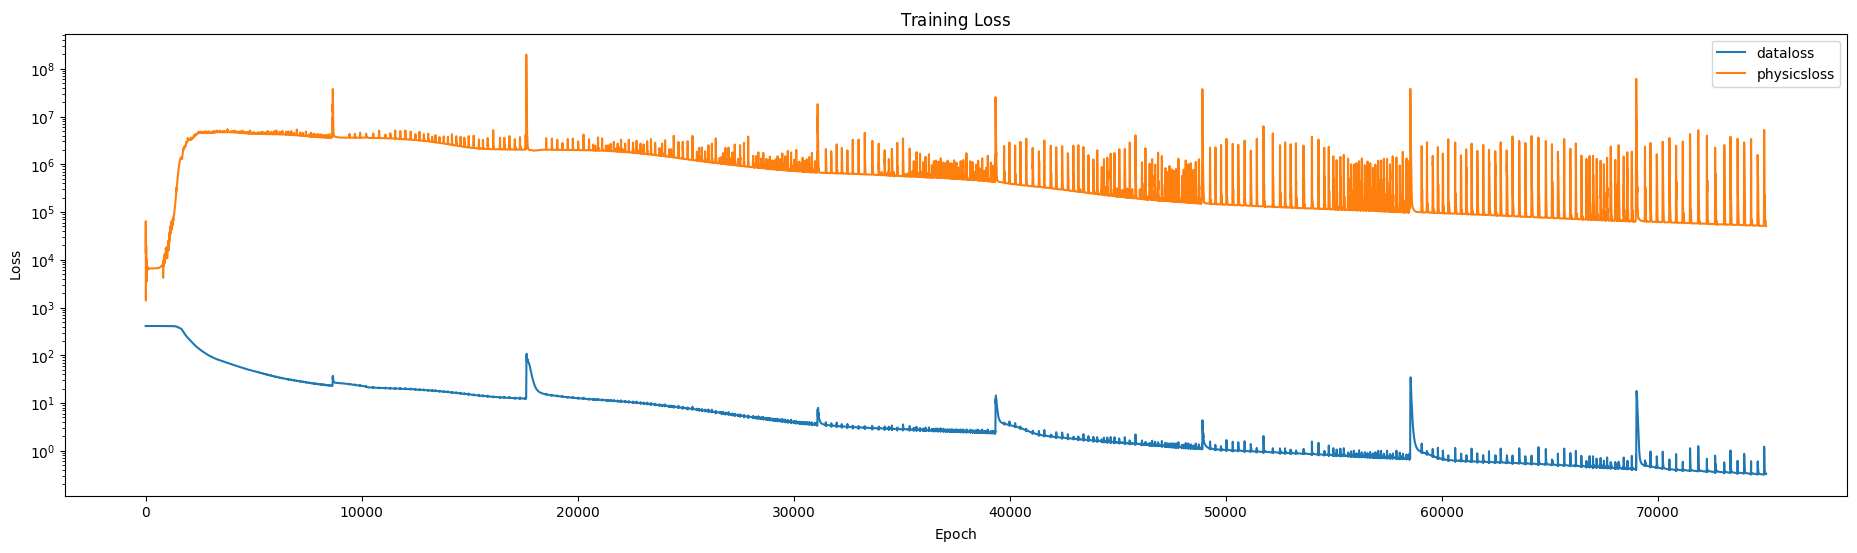

In [35]:
m = 1
# k = 1
# mu = 0.1
mu, k = 2*d, w0**2
x_0 = 1
v_0 = 0

torch.manual_seed(123)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

x_train = torch.tensor(X.query("time <= 0.75")["time"].values).float().unsqueeze(1).to(device)
y_train = torch.tensor(X.query("time <= 0.75")["displacement"].values).float().unsqueeze(1).to(device)

x_test = torch.tensor(X.query("time > 0.75")["time"].values).float().unsqueeze(1).to(device)
y_test = torch.tensor(X.query("time > 0.75")["displacement"].values).float().unsqueeze(1).to(device)

hparam_dict = {
    'learning_rate': 1e-3,
    'n_layers': 3,
    'n_neurons': 32,
    'num_epochs': 75000,
 }

learning_rate = hparam_dict["learning_rate"]
num_epochs = hparam_dict["num_epochs"]
architecture = [1] + [hparam_dict["n_neurons"] for _ in range(hparam_dict["n_layers"])] + [1]

model = MultiLayerPerceptronRegressor(architecture, nn.GELU)
model = MultiLayerPerceptronRegressor(architecture, nn.Tanh)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(model)

plot_loss_train = dict(epoch=[], dataloss=[], physicsloss=[])

_locations = torch.linspace(0, 0.75, 50).view(-1,1).requires_grad_(True).to(device)
_m = torch.tensor(m, dtype=torch.float, requires_grad=False).to(device)
_mu = torch.tensor(mu, dtype=torch.float, requires_grad=False).to(device)
_k = torch.tensor(k, dtype=torch.float, requires_grad=False).to(device)
_x0 = torch.tensor(X["displacement"][0], dtype=torch.float, requires_grad=False).to(device)
_v0 = torch.tensor(v_0, dtype=torch.float, requires_grad=False).to(device)

for epoch in tqdm.tqdm(range(hparam_dict["num_epochs"])):
    optimizer.zero_grad()

    # forward
    y_train_hat = model(x_train)
    data_loss = criterion(y_train_hat, y_train)

    y_location_hat = model(_locations)
    dydt = torch.autograd.grad(y_location_hat, _locations, grad_outputs=torch.ones_like(y_location_hat), create_graph=True)[0]
    dy2dt2 = torch.autograd.grad(dydt, _locations, grad_outputs=torch.ones_like(dydt), create_graph=True)[0]

    _x0_loss = criterion(y_location_hat[0], _x0)
    _v0_loss = criterion(dydt[0], _v0)

    _diff_equation = _m*dy2dt2 + _mu*dydt + _k*y_location_hat
    
    physics_loss = criterion(_diff_equation, torch.zeros_like(_diff_equation))

    loss = data_loss + (1e-5)*(physics_loss)# + (1e-3)*(_x0_loss) + (1e-3)*(_v0_loss)
    
    # backward
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 1000 == 0:
        str_epoch = str(epoch+1).zfill(5)
        str_num_epochs = str(num_epochs).zfill(5)
        str_loss = str(round(loss.item(), 4))
        str_physics_loss = str(round(physics_loss.item(), 4))
        # print(f"epoch [{str_epoch}/{str_num_epochs}] loss: {str_loss} physics loss: {str_physics_loss}")
        print("mass = ", _m.item(), "damping = ", _mu.item(), "spring = ", _k.item())
        print(f"Data Loss: {data_loss.item():.6f}, Physics Loss: {physics_loss.item():.6f}, x0 Loss: {_x0_loss.item():.6f}, v0 Loss: {_v0_loss.item():.6f}, Total Loss: {loss.item():.6f}")

    if (epoch+1) % 5 == 0:
        plot_loss_train["epoch"].append(epoch+1)
        plot_loss_train["dataloss"].append(data_loss.item())
        plot_loss_train["physicsloss"].append(physics_loss.item())
    
    if loss.item() <= 0.015:
        print("DONE!")
        break

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

pd.DataFrame(plot_loss_train).plot(x="epoch", y="dataloss", figsize=(23, 6), ax=ax1)
pd.DataFrame(plot_loss_train).plot(x="epoch", y="physicsloss", figsize=(23, 6), ax=ax1)
ax1.set_xlabel(r"$\mathrm{Epoch}$")
ax1.set_ylabel(r"$\mathrm{Loss}$")
ax1.set_title(r"$\mathrm{Training}$ $\mathrm{Loss}$")

ax1.set_yscale('log')

plt.savefig("../data/08_reporting/figures/oscilador_harmonico_loss_pinn.png", dpi=300, bbox_inches="tight") ;

# results

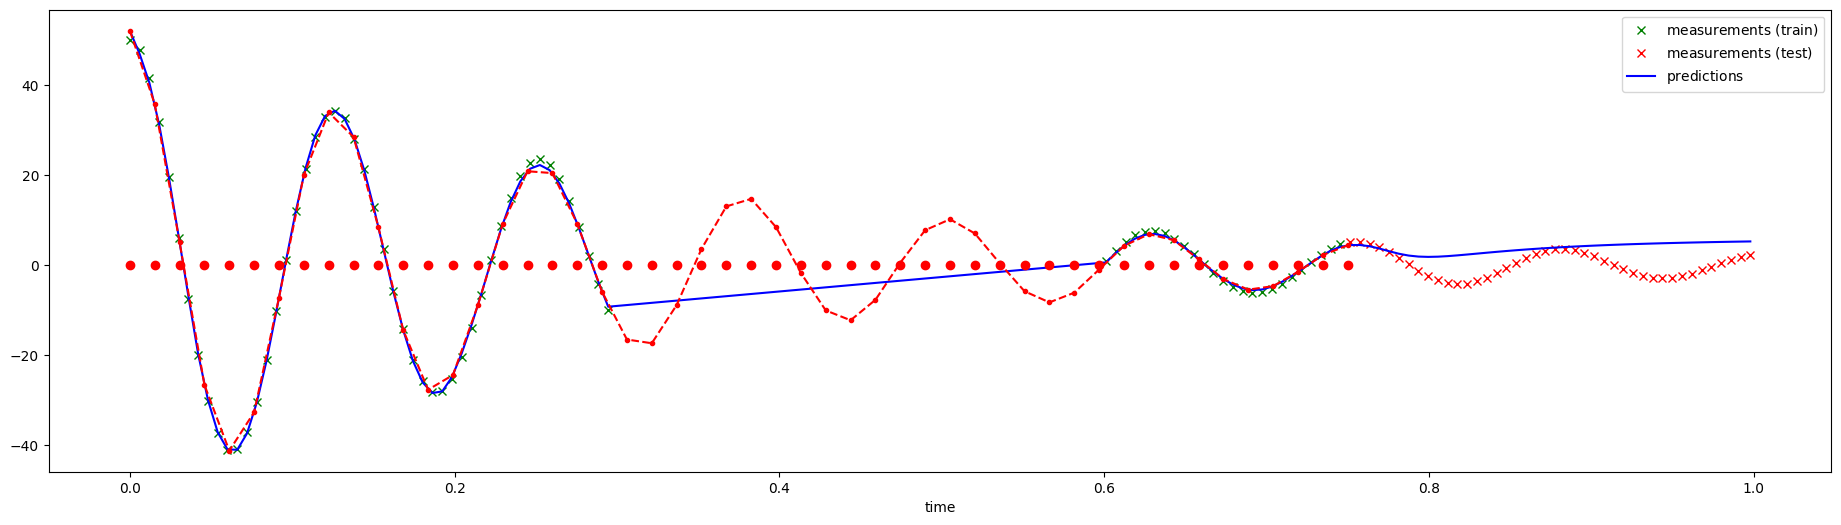

In [39]:
model.eval()

with torch.no_grad():
    X["y_hat"] = model(torch.tensor(X["time"].values).float().unsqueeze(1).to(device)).cpu().detach().numpy()

fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(23, 6))

X.query("time <= 0.75").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="g", linestyle="none", 
    label=r"$\text{measurements (train)}$"
)

X.query("time > 0.75").plot(
    x="time", 
    y="displacement", 
    ax=ax1,
    marker="x", c="r", linestyle="none", 
    label=r"$\text{measurements (test)}$"
)

X.plot(
    x="time", 
    y="y_hat", 
    ax=ax1,
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1)*0, 
    c="r", linestyle="none", marker="o",
    label=r"$\text{locations}$"
)

ax1.plot(
    _locations.cpu().detach().numpy().reshape(-1, 1),
    model(_locations).cpu().detach().numpy().reshape(-1), 
    c="r", linestyle="--", marker=".",
    label=r"$\text{locations prediction}$"
)

# # plot theoretical curve
# m = 1
# k = 1
# mu = 0.1
# x_0 = 1
# v_0 = 0

# omega_0 = np.sqrt(k/m)
# delta = mu/(2*m)
# omega = np.sqrt(omega_0**2 - delta**2)

# t = np.linspace(0, 50, 1000)
# x = np.exp(-delta*t)*(x_0*np.cos(omega*t) + (v_0 + delta*x_0)/omega*np.sin(omega*t))
# ax1.plot(
#     t.reshape(-1, 1),
#     x, 
#     c="k", linestyle="--", 
#     label=r"$\text{exact solution}$"
# )

# ax1.set_xlabel(r"$\mathrm{time}$ $\mathrm{(s)}$")
# ax1.set_ylabel(r"$\mathrm{displacement}$ $\mathrm{(m)}$")
# ax1.set_title(r"$\mathrm{Damped}$ $\mathrm{Harmonic}$ $\mathrm{Oscillator}$")

# plt.suptitle(f"MSE = {round(mean_squared_error(X['displacement'], X['y_hat']), 4)}")
# ax1.legend()

# plt.savefig("../data/08_reporting/figures/oscilador_harmonico_predictions_pinn.png", dpi=300, bbox_inches="tight") ;

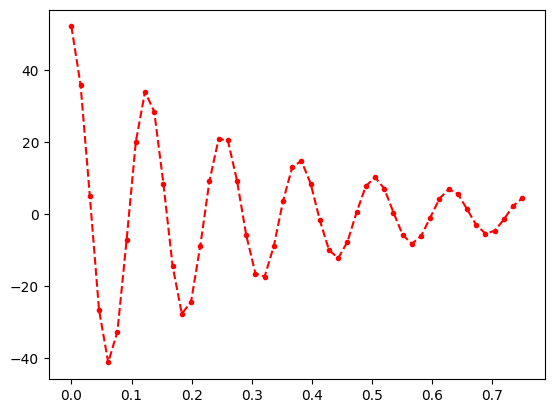

In [40]:
model.eval()
with torch.no_grad():
    plt.plot(
        _locations.cpu().detach().numpy().reshape(-1, 1),
        model(_locations).cpu().detach().numpy().reshape(-1), 
        c="r", linestyle="--", marker=".",
        label=r"$\text{locations prediction}$"
    )

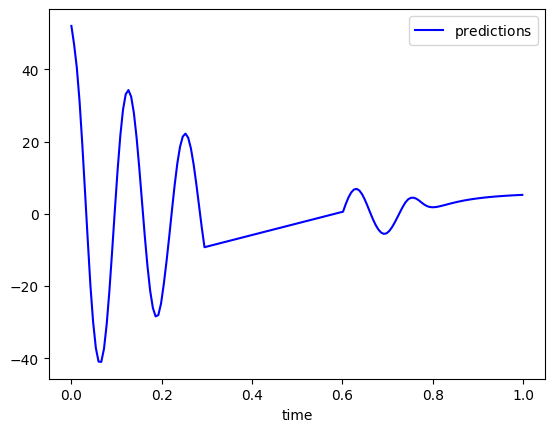

In [41]:
X.plot(
    x="time", 
    y="y_hat",
    c="b", linestyle="-", 
    label=r"$\text{predictions}$"
) ;

.